In [433]:
%matplotlib inline
import re
import numpy as np
import pandas as pd

from IPython.display import display, HTML
from pathlib import Path
from matplotlib import pyplot as plt
from datetime import datetime

In [434]:
def extract(string, key, dtype):
    if dtype is bool:
        return True if re.search(' {}=((True)|(False)) '.format(key), string).group(1) == 'True' else False
    if dtype is float:
        return float(re.search(' {}=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?)'.format(key), string).group(1))
    if dtype is int:
        return float(re.search(' {}=(\d+) '.format(key), string).group(1))

def get_result_metrics(filepath):
    # get lines with results
    lines = []
    marker = 'Got result: '
    with open(filepath) as f:
        for line in f.readlines():
            if marker in line:
                lines.append(line.split(marker, 1)[1])
    
    # extract metrics
    runs = []
    for run in lines:
        data = {
            #'success': extract(run, 'success', bool),
            'time_created': extract(run, 'time_created', float),
            'time_input_received': extract(run, 'time_input_received', float),
            'time_compute_started': extract(run, 'time_compute_started', float),
            'time_result_sent': extract(run, 'time_result_sent', float),
            'time_result_received': extract(run, 'time_result_received', float),
            'time_running': extract(run, 'time_running', float),
            'time_serialize_inputs': extract(run, 'time_serialize_inputs', float),
            'time_deserialize_inputs': extract(run, 'time_deserialize_inputs', float),
            'time_serialize_results': extract(run, 'time_serialize_results', float),
            'time_deserialize_results': extract(run, 'time_deserialize_results', float),
            'time_result_received': extract(run, 'time_result_received', float),
        }
        

        
        data['client_to_method_server'] = data['time_input_received'] - (
                data['time_created'] + data['time_serialize_inputs'])
        data['worker_to_method_server'] = data['time_result_sent'] - (
                data['time_compute_started'] + data['time_running'] + 
                data['time_deserialize_inputs'] + data['time_serialize_results'])
        data['method_server_to_client'] = data['time_result_received'] - (
                data['time_result_sent'] + data['time_deserialize_results'])
        data['time_serialization'] = sum(data[key] for key in data if 'serialize' in key)
        data['time_created_to_result_received'] = data['time_result_received'] - data['time_created']
        
        runs.append(data)
    
    return pd.DataFrame(runs)

def aggregate_runs(run_paths):
    data = []
    for path in run_paths:
        results = pd.Series({'path': path})

        with open(path) as f:
            first_line = f.readline()
            timestamp = first_line.split(' - ')[0]
            value_server = True if re.search('use_value_server=(.+),', first_line).group(1) == 'True' else False
            results['value_server'] = value_server
            results['task_count'] = int(re.search('task_count=(\d+),', first_line).group(1))
            results['task_input_size'] = int(re.search('task_input_size=(\d+),', first_line).group(1))
            results['task_interval'] = float(re.search('task_interval=(\d+(\.\d+)?(?:[eE][+\-]?\d+)?),', first_line).group(1))
            results['task_output_size'] = int(re.search('task_output_size=(\d+),', first_line).group(1))
            results['time_start'] = datetime.strptime(timestamp, "%Y-%m-%d %H:%M:%S,%f").timestamp()
            
            to_proxy_times = []
            for line in f.readlines():
                if 'to_proxy_time=' in line:
                    to_proxy_times.append(extract(line, 'to_proxy_time', float))
            results['to_value_server_time'] = np.median(to_proxy_times) if len(to_proxy_times) > 0 else 0

        function_results = get_result_metrics(path)
        results['n_tasks'] = len(function_results.index)
        results['total'] = None
        results = pd.concat([results, function_results.median()])
                
        data.append(results)
        
    return pd.concat(data, axis=1).T

In [459]:
cols = ['client_to_method_server', 'worker_to_method_server', 'method_server_to_client', 'time_serialization', 'to_value_server_time', 'time_running']
ind = np.arange(len(cols))
width = 0.35

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_reuse_30s_50x50/2021-02-16_23-0...,False,50,50,15,0,1.61352e+09,0,50,None,...,0.01046,0.000161834,0.000773301,0.000870031,0.000146902,0.00161815,0.00515652,0.00165379,0.00198728,0.036919
1,runs/full_test_reuse_30s_50x50/2021-02-16_23-2...,True,50,50,15,0,1.61352e+09,0.000254869,50,None,...,0.0103267,5.00115e-05,0.000170711,0.000341923,7.09424e-05,0.000748515,0.00513208,0.000612259,0.000636162,0.0340531


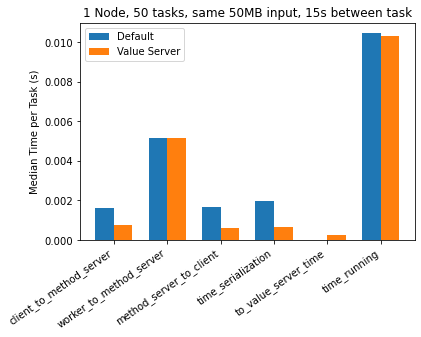

In [461]:
rundir = 'runs/full_test_reuse_30s_50x50/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['time_running'] = results['time_running']
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, same 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()

,path,value_server,task_count,task_input_size,task_interval,task_output_size,time_start,to_value_server_time,n_tasks,total,...,time_running,time_serialize_inputs,time_deserialize_inputs,time_serialize_results,time_deserialize_results,client_to_method_server,worker_to_method_server,method_server_to_client,time_serialization,time_created_to_result_received
0,runs/full_test_unique_30s_50x50/2021-02-16_23-...,False,50,50,15,0,1.61352e+09,0,50,None,...,0.0103396,0.000160891,0.000770695,0.000864466,0.000153352,0.00155175,0.00498819,0.0016799,0.00200739,0.0375686
1,runs/full_test_unique_30s_50x50/2021-02-17_00-...,True,50,50,15,0,1.61352e+09,0.000261426,50,None,...,0.0105738,5.2989e-05,0.000165901,0.000356088,7.4301e-05,0.000786424,0.00533581,0.000629187,0.000644933,0.0317279


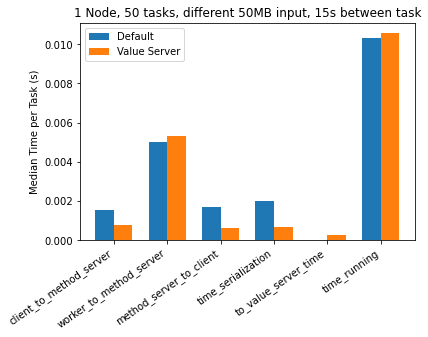

In [462]:
rundir = 'runs/full_test_unique_30s_50x50/'
run_paths = list(map(str, Path(rundir).rglob('*runtime.log')))
results = aggregate_runs(run_paths)
results['time_running'] = results['time_running']
display(results)

no_value_server = results.loc[results['value_server'] == False][cols]
value_server = results.loc[results['value_server'] == True][cols]

width = 0.35
fig, ax = plt.subplots()
plt.bar(ind, no_value_server.to_numpy()[0], width, label='Default')
plt.bar(ind+width, value_server.to_numpy()[0], width, label='Value Server')

plt.title('1 Node, 50 tasks, different 50MB input, 15s between task')
plt.ylabel('Median Time per Task (s)')
ax.set_xticks(ind + width/2) 
ax.set_xticklabels(cols, ha="right", rotation=35)
plt.legend(loc='best')
plt.show()